In [ ]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim

Questions Andreas:
- How is Epsilon updated?

In [ ]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [ ]:
data = pd.read_csv('covid19model.csv')
data

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,1.300600e-02
1,2020-02-18,0,0.087065,3.004645e-02
2,2020-02-19,0,0.112061,4.467391e-02
3,2020-02-20,0,0.119346,5.547300e-02
4,2020-02-21,0,0.114540,6.242203e-02
...,...,...,...,...
402,2021-03-25,38,0.000000,2.817211e-32
403,2021-03-26,31,0.000000,2.349426e-32
404,2021-03-27,39,0.000000,1.959313e-32
405,2021-03-28,32,0.000000,1.633974e-32


In [ ]:
def trunc_exponential(scale, upper):
    sample = torch.distributions.exponential.Exponential(1/scale).rsample()
    sample = sample/torch.tensor(1-torch.exp(-upper/scale))
    return sample
# torch.distributions.exponential.Exponential(1/scale).sample()/torch.tensor(1-torch.exp(-upper/scale))

def trunc_normal(mu, sigma, under, upper):
    distribution = torch.distributions.normal.Normal(loc=mu, scale=sigma, validate_args=None)
    normal_sample = distribution.rsample()
    cumulative = distribution.cdf(torch.tensor(upper)) - distribution.cdf(torch.tensor(under))
    return normal_sample/cumulative

# Initialization


In [ ]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

## Initialize latent variables/parameters

In [ ]:
"""tau = np.random.exponential(1 / 0.03)
tau_t = torch.tensor(tau, requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = torch.tensor(truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau), requires_grad=False, device=device, dtype=dtype)  # number of initial newly_infected (seed)"""


tau= torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
phi = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True, device=device, dtype=dtype)  # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype)  # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True, device=device, dtype=dtype)  # standart deviation of random walk step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


This is a way to generate the initial params from pytorch distribution directly without truncation.
NOTE: Use either this code block below or above.

In [ ]:
dist_tau_t = distributions.exponential.Exponential(torch.tensor([1/0.03], device=device))
#tau_t = dist_tau_t.sample()

dist_y = distributions.exponential.Exponential(tau)
#y = dist_y.sample()

dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))
#phi = dist_phi.sample()

dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))
#R0 = dist_R0.sample()

dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device), scale=torch.tensor([0.01], device=device))
#alpha = dist_alpha.sample()

dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.1], device=device), scale=torch.tensor([0.3], device=device))
#sigma = dist_sigma.sample()

In [ ]:
#epsilon_t = torch.randn(num_observations, requires_grad=True, device=device, dtype=dtype)
epsilon_t = torch.zeros(num_observations, device=device)

In [ ]:
epsilon_t[0] = torch.distributions.Normal(cero, sigma).rsample()
for t in range(1, num_observations):
  epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].clone(), sigma).rsample()

# Define Forward Pass

In [ ]:
def forward_pass():
  epsilon_t.retain_grad()
  # Initialize time series variables
  y = trunc_exponential(tau, 1000)
  newly_infected = torch.zeros(num_observations, device=device)  # number of newly infected
  effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals
  expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations
  cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected
  eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
  #epsilon_t = torch.zeros(num_observations, device=device)  # random walk
  St = torch.zeros(num_observations, device=device)  # fraction of susceptible population

  # log likelihood wrt. our prior ("regularisation")
  # ll stands for log-likelihood
  ll = torch.tensor(0.0, device=device)

  #dist_tau_t = distributions.exponential.Exponential(torch.tensor([1/0.03]))
  ll += dist_tau_t.log_prob(tau).item()

  #dist_y = distributions.exponential.Exponential(tau) #the parameter in the brasket should either be float or tensor, to avoid any inconvienience,
                                                      # I use everything as tensor. NOTE:tau_t is already a tensor.
  #ll += dist_y.log_prob(y).item()

  #dist_phi = distribution.normal.Normal(loc=torch.tensor([25]), scale=torch.tensor([10]))
  ll += dist_phi.log_prob(phi).item()

  #dist_R0 = distribution.normal.Normal(loc=torch.tensor([3.6]), scale=torch.tensor([0.8]))
  ll += dist_R0.log_prob(R0).item()

  #dist_alpha = distribution.normal.Normal(loc=torch.tensor([0.01]), scale=torch.tensor([0.01]))
  ll += dist_alpha.log_prob(alpha).item()

  #dist_sigma = distribution.normal.Normal(loc=torch.tensor([0.1]), scale=torch.tensor([0.3]))
  #ll += dist_sigma.log_prob(sigma).item()


  # seed initial infection / impute first num_impute days
  newly_infected[0:num_impute] = y.clone()
  cumulative_infected[0] = 0.
  cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
  St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])

  # calculate Rt: the basic reproduction number
  # basic reproduction number as a latent random walk
  beta_0 = torch.log(R0)
  eta_t[0] = beta_0
  #epsilon_t[0] = torch.distributions.Normal(cero, sigma).rsample()
  for t in range(1, num_observations):
      #epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].clone(), sigma).rsample()
      dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
      ll += dist_epsilon_t.log_prob(epsilon_t[t - 1]).item() #epsilon_t.log_prob(epsilon_t[t - 1]) ---> Andreas: whats the correct regularization - epsilon or eta? 
  eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations-1].clone() # 	--> Andreas:	ηt[t] = ϵt[t-1] # + RNN[X_t, t] - add beta_0 to all values or only equals eta_t[0] 
  Rt = torch.exp(eta_t)

  # calculate infections
  for t in range(num_impute, num_observations):
      # Update cumulative newly_infected
      cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
      # Adjusts for portion of pop that are susceptible
      St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
      # effective number of infectous individuals

      for i in range(0, t-1): # correct range or change to (0, t) ?
          effectively_infectious[t] += newly_infected[i].clone() * serial_interval[t - i].clone()
      newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()

  # calculate expected number of hospitalizations
  expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
  for t in range(1, num_observations):
      for i in range(0, t):
          expected_daily_hospit[t] += newly_infected[i].clone() * pi[t - i].clone()
  expected_daily_hospit = alpha * expected_daily_hospit

  # compare observed hospitalizations to model results
  # likelihood of the data wrt. to the model

  for i in range(0, num_observations):

      p = 1/(1+ expected_daily_hospit[i]/phi)
      dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p-torch.tensor(2.225e-5))
      ll += dist.log_prob(observed_daily_hospit[i])


  return expected_daily_hospit, Rt, ll

# Optimization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 0|| Loss: 67492.5703125,  R0:4.465103250110381, grad: -12039.694819469412, alpha: 0.010002519894707206 grad: 259746.1953125, phi: 20.07745263261484 grad: 7659.491563376298, epsilon_t.mean: -0.37736332416534424 grad.mean -132.08473205566406
This Run:  15.123412132263184 seconds


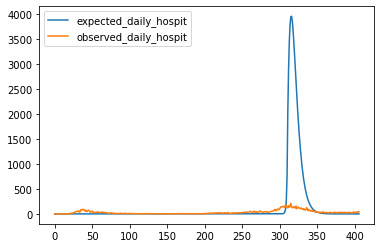

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 1|| Loss: 66619.109375,  R0:4.465115289805201, grad: 6657.3597716772165, alpha: 0.010002260148511893 grad: 89014.890625, phi: 20.077444973123278 grad: 2424.8321052759347, epsilon_t.mean: -0.3772311806678772 grad.mean 73.03656005859375
This Run:  16.10064673423767 seconds


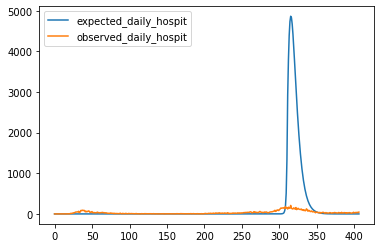

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 2|| Loss: 68182.3828125,  R0:4.465108632445429, grad: -337.28622913604295, alpha: 0.010002171133621268 grad: 87457.5234375, phi: 20.077442548291174 grad: 2559.6969628887705, epsilon_t.mean: -0.3773042559623718 grad.mean -3.700294017791748
This Run:  15.316180229187012 seconds


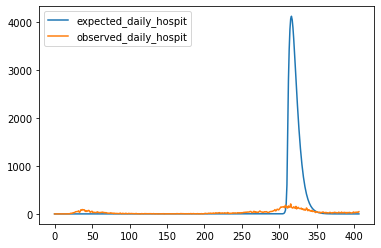

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 3|| Loss: 63143.2109375,  R0:4.465108969731658, grad: 1422.5038646720232, alpha: 0.01000208367609783 grad: 79249.25, phi: 20.07743998859421 grad: 2241.0500770273575, epsilon_t.mean: -0.377300500869751 grad.mean 15.605981826782227
This Run:  16.178723573684692 seconds


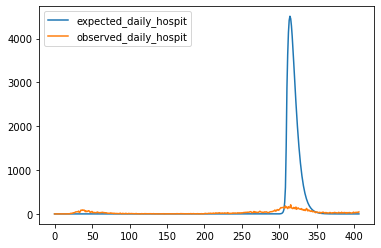

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 4|| Loss: 63411.05078125,  R0:4.4651075472277935, grad: 6291.266524602681, alpha: 0.010002004426847831 grad: 78699.3046875, phi: 20.077437747544135 grad: 2263.9520998751, epsilon_t.mean: -0.3773161768913269 grad.mean 69.02010345458984
This Run:  15.26131534576416 seconds


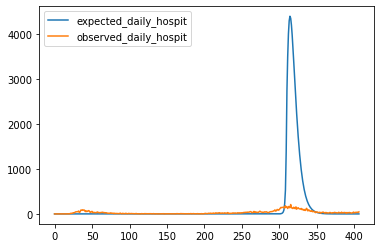

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 5|| Loss: 69206.7421875,  R0:4.465101255961269, grad: -20885.763060914767, alpha: 0.010001925727543144 grad: 90861.828125, phi: 20.077435483592033 grad: 2617.7825767241266, epsilon_t.mean: -0.3773851692676544 grad.mean -229.13279724121094
This Run:  15.739514112472534 seconds


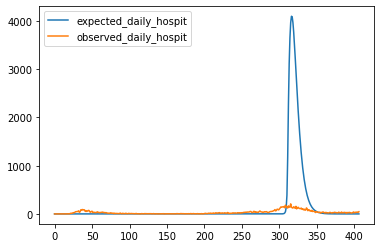

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 6|| Loss: 67064.1875,  R0:4.46512214172433, grad: 16611.70963429814, alpha: 0.010001834865715018 grad: 84660.3671875, phi: 20.077432865809456 grad: 2491.814791394839, epsilon_t.mean: -0.3771560490131378 grad.mean 182.2440185546875
This Run:  16.37916874885559 seconds


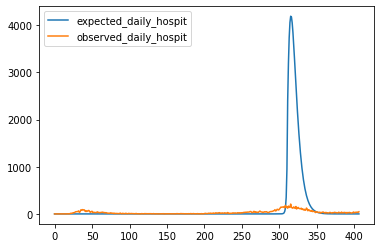

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 7|| Loss: 68474.4921875,  R0:4.465105530014696, grad: 6298.80260843072, alpha: 0.010001750205347831 grad: 87416.7265625, phi: 20.077430373994666 grad: 2582.5044920754467, epsilon_t.mean: -0.37733832001686096 grad.mean 69.10274505615234
This Run:  15.698284387588501 seconds


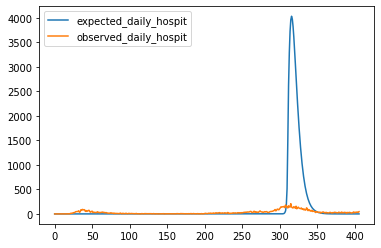

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 8|| Loss: 63215.78125,  R0:4.465099231212087, grad: 3714.6304036052843, alpha: 0.010001662788621269 grad: 78815.46875, phi: 20.077427791490173 grad: 2248.650065424862, epsilon_t.mean: -0.37740737199783325 grad.mean 40.7523193359375
This Run:  16.079608917236328 seconds


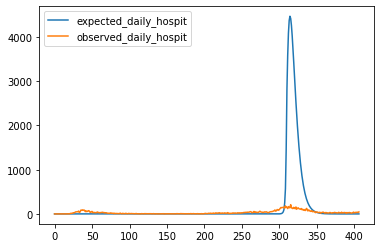

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 9|| Loss: 60801.05078125,  R0:4.465095516581684, grad: 14005.967877452445, alpha: 0.010001583973152518 grad: 71244.7109375, phi: 20.077425542840107 grad: 2140.1662393247307, epsilon_t.mean: -0.37744811177253723 grad.mean 153.65597534179688
This Run:  14.941565036773682 seconds


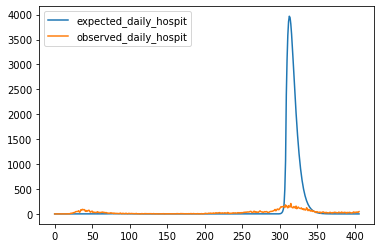

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 10|| Loss: 74641.28125,  R0:4.465081510613807, grad: 16644.478482271537, alpha: 0.01000151272844158 grad: 143298.03125, phi: 20.07742340267387 grad: 2928.608980442178, epsilon_t.mean: -0.3776018023490906 grad.mean 182.6018524169922
This Run:  14.847578763961792 seconds


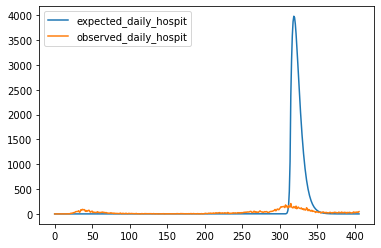

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 11|| Loss: 64975.71484375,  R0:4.465064866135324, grad: -21503.7189556229, alpha: 0.01000136943041033 grad: 83341.4296875, phi: 20.077420474064887 grad: 2344.7379718255675, epsilon_t.mean: -0.37778446078300476 grad.mean -235.9103240966797
This Run:  15.036860227584839 seconds


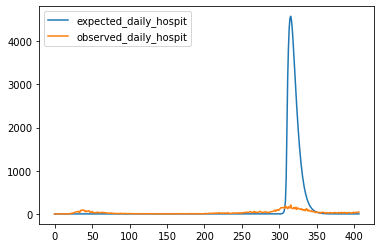

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 12|| Loss: 65260.02734375,  R0:4.46508636985428, grad: -16771.53657778941, alpha: 0.010001286088980642 grad: 84937.75, phi: 20.077418129326915 grad: 2353.511761701507, epsilon_t.mean: -0.37754854559898376 grad.mean -183.9959716796875
This Run:  16.368882656097412 seconds


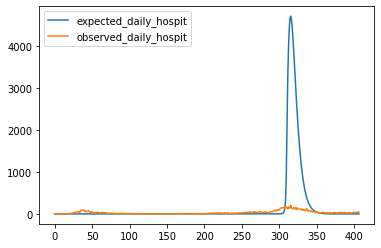

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 13|| Loss: 66958.65625,  R0:4.465103141390858, grad: 16276.349240694562, alpha: 0.010001201151230642 grad: 84258.1328125, phi: 20.077415775815155 grad: 2485.3619900657245, epsilon_t.mean: -0.37736451625823975 grad.mean 178.56407165527344
This Run:  16.128366708755493 seconds


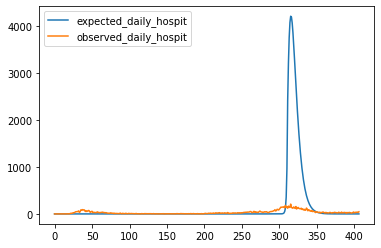

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 14|| Loss: 65357.63671875,  R0:4.465086865041617, grad: -14546.707480324598, alpha: 0.01000111689309783 grad: 85395.171875, phi: 20.077413290453165 grad: 2356.8460349591123, epsilon_t.mean: -0.37754303216934204 grad.mean -159.58799743652344
This Run:  15.475723028182983 seconds


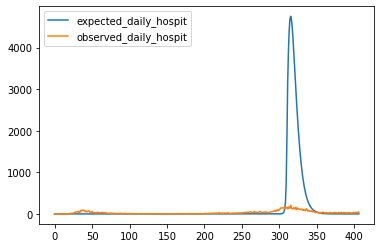

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 15|| Loss: 65658.96875,  R0:4.465101411749098, grad: -9219.293860365997, alpha: 0.010001031497925954 grad: 86762.7109375, phi: 20.07741093360713 grad: 2368.4822368059827, epsilon_t.mean: -0.37738344073295593 grad.mean -101.14270782470703
This Run:  15.319614171981812 seconds


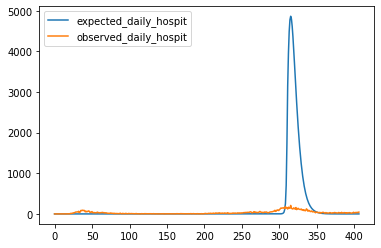

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 16|| Loss: 67029.1171875,  R0:4.4651106310429585, grad: 18348.005630683285, alpha: 0.010000944735215017 grad: 81949.8984375, phi: 20.077408565124895 grad: 2508.288770451519, epsilon_t.mean: -0.37728238105773926 grad.mean 201.29208374023438
This Run:  15.991801977157593 seconds


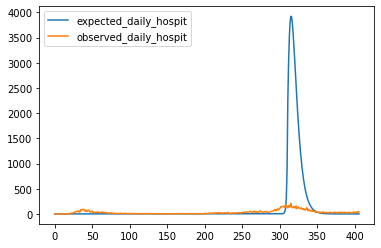

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 17|| Loss: 66612.4765625,  R0:4.465092283037328, grad: 10072.174246174258, alpha: 0.01000086278531658 grad: 87001.046875, phi: 20.077406056836125 grad: 2436.9048617079316, epsilon_t.mean: -0.3774835765361786 grad.mean 110.49922943115234
This Run:  16.471263647079468 seconds


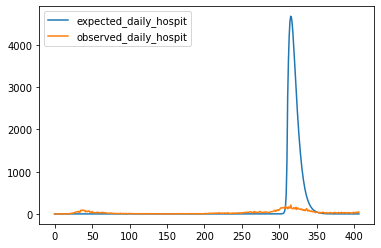

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 18|| Loss: 68047.28125,  R0:4.465082210863082, grad: -50.30224699255328, alpha: 0.010000775784269705 grad: 86608.3984375, phi: 20.077403619931264 grad: 2552.515095463487, epsilon_t.mean: -0.37759411334991455 grad.mean -0.551851749420166
This Run:  15.796063661575317 seconds


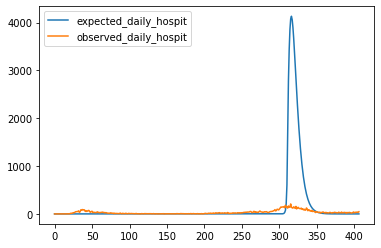

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 19|| Loss: 71070.5234375,  R0:4.465082261165329, grad: 14402.878894714004, alpha: 0.010000689175871267 grad: 97989.78125, phi: 20.07740106741617 grad: 2728.8377763314866, epsilon_t.mean: -0.3775935471057892 grad.mean 158.00991821289062
This Run:  15.6399085521698 seconds


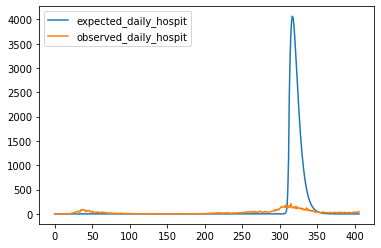

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 20|| Loss: 61524.96484375,  R0:4.465067858286434, grad: -22518.8416931669, alpha: 0.010000591186090018 grad: 74153.6640625, phi: 20.07739833857839 grad: 2166.4612376308532, epsilon_t.mean: -0.37775155901908875 grad.mean -247.0470733642578
This Run:  15.848023414611816 seconds


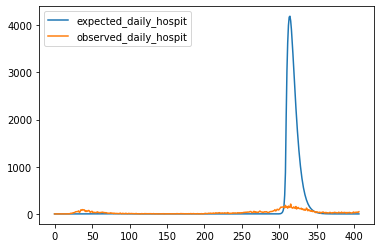

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 21|| Loss: 64943.83984375,  R0:4.465090377128128, grad: -21507.074468617044, alpha: 0.010000517032425955 grad: 82758.625, phi: 20.077396172117155 grad: 2345.3483110656684, epsilon_t.mean: -0.3775045871734619 grad.mean -235.948486328125
This Run:  15.069204330444336 seconds


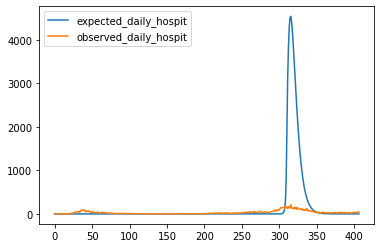

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 22|| Loss: 71119.671875,  R0:4.465111884202597, grad: 14815.659683478247, alpha: 0.010000434273800955 grad: 98086.953125, phi: 20.077393826768844 grad: 2733.895172864239, epsilon_t.mean: -0.37726858258247375 grad.mean 162.5395050048828
This Run:  15.434001684188843 seconds


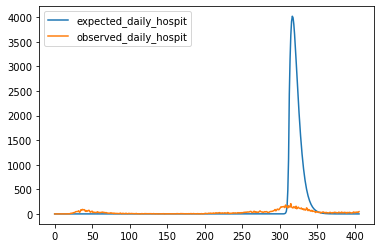

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 23|| Loss: 63753.53125,  R0:4.465097068542914, grad: 14824.261289038499, alpha: 0.01000033618684783 grad: 74384.1875, phi: 20.077391092873672 grad: 2318.2719789417924, epsilon_t.mean: -0.37743112444877625 grad.mean 162.63333129882812
This Run:  15.350672006607056 seconds


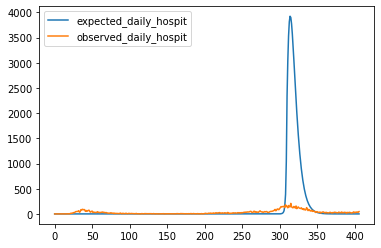

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Time Step: 24|| Loss: 71056.0078125,  R0:4.465082244281625, grad: 14896.707338971182, alpha: 0.010000261802660329 grad: 97460.5390625, phi: 20.077388774601694 grad: 2731.734979733348, epsilon_t.mean: -0.3775937259197235 grad.mean 163.42758178710938
This Run:  16.103882312774658 seconds


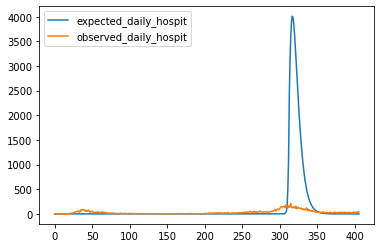

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 1e-6
complete_time = time.time()

for k in range (400):
    start_time = time.time()
    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll = forward_pass()

    #backward pass
    loss = -ll
    loss.backward()

    print(f'Time Step: {k}|| Loss: {loss},  R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, phi: {phi} grad: {phi.grad}, epsilon_t.mean: {epsilon_t.mean()} grad.mean {epsilon_t.grad.mean()}') # sigma: {sigma} grad {sigma.grad}

    with torch.no_grad(): # this part is SGD. can also replace with loss.step
        tau -= learning_rate * tau.grad
        phi -= learning_rate * phi.grad * 1e-3
        R0 -= learning_rate * R0.grad * 1e-3
        alpha -= learning_rate * alpha.grad * 1e-6
        #sigma -= learning_rate * sigma.grad * 1e-6
        epsilon_t -= learning_rate * epsilon_t.grad

        tau.grad = None
        phi.grad = None
        R0.grad = None
        alpha.grad = None
        #sigma.grad = None
        epsilon_t.grad = None

    epsilon_t = epsilon_t.detach()
    epsilon_t.requires_grad_(True)

        
    print("This Run:  %s seconds" % (time.time() - start_time))
    plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
    plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
    plt.legend()
    plt.show()


print("Complete Run:  %s seconds" % (time.time() - complete_time))